<a href="https://colab.research.google.com/github/jbarsce/AprendizajePorRefuerzos/blob/master/lab_1_intro_rl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 1: Introducción al aprendizaje por refuerzos

Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

Facultad de Matemática, Astronomía, Física y Computación, Universidad Nacional de Córdoba

# **Estudiante:**
    - Zamorano Maria Micaela

# **Docentes:**
     - Juan Barsce
     - Jorge Palombarini

## Introducción

En el siguiente notebook se muestra cómo ejecutar agentes de aprendizaje por refuerzos, los cuáles son necesarios para realizar este Lab.

### Repaso rápido



* Recompensa: señal $r$ recibida desde el entorno que recompensa o castiga el agente según su desempeño con respecto al objetivo de la tarea.

* Valor: función $v_\pi (s)$ que establece cuánto el agente espera percibir de recompensa al seguir la política $\pi$ partiendo desde el estado $s$. También se la suele expresar como $Q_\pi(s,a)$, indicando cuánto el agente espera percibir siguiendo la política $\pi$ partiendo desde el estado $s$ y siguiendo la acción $a$.

* Política: función $\pi(s) \to a$ que mapea un estado a una acción. Se suele expresar como probabilidad de elegir la acción $\pi(a \mid s)$. La política $\epsilon$-greedy, en donde $\epsilon$ es la probabilidad de exploración (normalmente menor que la probabilidad de explotación) está dada por $\pi(a \mid s) = 1 - \epsilon$ si $a$ es la mejor acción, caso contrario pasa a estar dada por $\pi(a \mid s) = \epsilon$.

Por otra parte, en la política Softmax, no se busca la acción con máxima probabilidad sino que se computa la probabilidad de cada una mediante la función Softmax y se realiza un sorteo entre ellas pesado por la misma. Así, para cada acción $a$, $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\widetilde{a} \in A}e^{Q(s,\widetilde{a})/\tau}}$$

En este notebook vemos dos algoritmos para actualizar la función de valor (y, por lo tanto, la política de selección de acciones):

* Actualización por SARSA (on-policy).

$$Q(s,a) \gets Q(s,a) + \alpha (r + \gamma Q(s',a') - Q(s,a))$$

Algoritmo completo (a modo de referencia):

![Algoritmo SARSA](https://github.com/DiploDatos/AprendizajePorRefuerzos/blob/master/images/sarsa.png?raw=1)


* Actualización por Q-Learning (off-policy)

$$Q(s,a) \gets Q(s,a) + \alpha (r + \gamma \arg\max_{a'} Q(s',a') - Q(s,a))$$

Algoritmo completo (a modo de referencia):

![Algoritmo Q-Learning](https://github.com/DiploDatos/AprendizajePorRefuerzos/blob/master/images/q_learning.png?raw=1)

Fuente de las imágenes: capítulo 6 de [Reinforcement Learning: An Introduction](http://www.incompleteideas.net/book/the-book.html).

## Librería a usar: Gymnasium (sucesora de OpenAI Gym)

[Gymnasium](https://github.com/Farama-Foundation/Gymnasium), es la librería que continúa con [OpenAI Gym](https://gym.openai.com/) (Brockman et. al., 2016), famosa librería de OpenAI que ofrece entornos y una interfaz estándar con la cuál probar nuestros agentes. Su objetivo es proveer benchmarks unificados para ver el desempeño de algoritmos en el entorno y así poder saber con facilidad cómo es su desempeño comparado con los demás. Parte de la siguiente sección está basada en la [documentación oficial de OpenAI](https://gym.openai.com/docs/).

La interfaz principal de los ambientes de gym es la interfaz Env. La misma posee cinco métodos principales:

* ```reset(self, seed)``` : Reinicia el estado del entorno, a su estado inicial, devolviendo una observación de dicho estado. Opcionalmente, establece la semilla aleatoria del generador de números aleatorios del presente entorno.

* ```step(self, action)``` : "Avanza" un timestep del ambiente. Devuelve: ```observation, reward, terminated, truncated, info```.

* ```render(self)``` : Muestra en pantalla una parte del ambiente.

* ```close(self)``` : Finaliza con la instancia del agente.


Por otra parte, cada entorno posee los siguientes tres atributos principales:

* ```action_space``` : El objeto de tipo Space correspondiente al espacio de acciones válidas.

* ```observation_space``` : El objeto de tipo Space correspondiente a todos los rangos posibles de observaciones.

* ```reward_range``` : Tupla que contiene los valores mínimo y máximo de recompensa posible.

Algunas de las ejecuciones contienen videos. Para poder verlos se necesita previamente instalar la librería ffmpeg; para instalarla desde Linux ejecutar en consola

```apt-get install ffmpeg```

desde Mac, reemplazar *apt-get* por *brew*

desde Windows, descargarla desde

[https://ffmpeg.org/download.html](https://ffmpeg.org/download.html)

(Nota: las animaciones son a modo ilustrativo, si no se desea instalar la librería se puede directamente eliminar la línea de código donde se llama al método ``env.render(mode='human')``)

Código básico de importación y funciones de graficación (no modificar)

In [1]:
# @title Código básico importacion y utilerías (no modificar)

import itertools
from typing import Any, Callable, Tuple

import numpy as np
import matplotlib.pyplot as plt


def plot_reward_per_episode(reward_ep) -> None:
    episode_rewards = np.array(reward_ep)

    # se suaviza la curva de convergencia
    episode_number = np.linspace(
        1, len(episode_rewards) + 1, len(episode_rewards) + 1)
    acumulated_rewards = np.cumsum(episode_rewards)

    reward_per_episode = [
        acumulated_rewards[i] / episode_number[i]
        for i in range(len(acumulated_rewards))
    ]

    plt.plot(reward_per_episode)
    plt.title("Recompensa acumulada por episodio")
    plt.show()


def plot_steps_per_episode(timesteps_ep) -> None:
    # se muestra la curva de aprendizaje de los pasos por episodio
    episode_steps = np.array(timesteps_ep)
    plt.plot(np.array(range(0, len(episode_steps))), episode_steps)
    plt.title("Pasos (timesteps) por episodio")
    plt.show()


def plot_steps_per_episode_smooth(timesteps_ep) -> None:
    episode_steps = np.array(timesteps_ep)

    # se suaviza la curva de aprendizaje
    episode_number = np.linspace(
        1, len(episode_steps) + 1, len(episode_steps) + 1)
    acumulated_steps = np.cumsum(episode_steps)

    steps_per_episode = [
        acumulated_steps[i] / episode_number[i] for i in range(
            len(acumulated_steps))
    ]

    plt.plot(steps_per_episode)
    plt.title("Pasos (timesteps) acumulados por episodio")
    plt.show()


def draw_value_matrix(q) -> None:
    n_rows = 4
    n_columns = 12
    n_actions = 4

    # se procede con los cálculos previos a la graficación de la matriz de valor
    q_value_matrix = np.empty((n_rows, n_columns))
    for row in range(n_rows):
        for column in range(n_columns):
            state_values = []

            for action in range(n_actions):
                state_values.append(
                    q.get((row * n_columns + column, action), -100))

            maximum_value = max(
                state_values
            )  # determinamos la acción que arroja máximo valor

            q_value_matrix[row, column] = maximum_value

    # el valor del estado objetivo se asigna en -1 (reward recibido al llegar)
    # para que se coloree de forma apropiada
    q_value_matrix[3, 11] = -1

    # se grafica la matriz de valor
    plt.imshow(q_value_matrix, cmap=plt.cm.RdYlGn)
    plt.tight_layout()
    plt.colorbar()

    for row, column in itertools.product(
        range(q_value_matrix.shape[0]), range(q_value_matrix.shape[1])
    ):
        left_action = q.get((row * n_columns + column, 3), -1000)
        down_action = q.get((row * n_columns + column, 2), -1000)
        right_action = q.get((row * n_columns + column, 1), -1000)
        up_action = q.get((row * n_columns + column, 0), -1000)

        arrow_direction = "D"
        best_action = down_action

        if best_action < right_action:
            arrow_direction = "R"
            best_action = right_action
        if best_action < left_action:
            arrow_direction = "L"
            best_action = left_action
        if best_action < up_action:
            arrow_direction = "U"
            best_action = up_action
        if best_action == -1:
            arrow_direction = ""

        # notar que column, row están invertidos en orden en la línea de abajo
        # porque representan a x,y del plot
        plt.text(column, row, arrow_direction, horizontalalignment="center")

    plt.xticks([])
    plt.yticks([])
    plt.show()

    print("\n Matriz de mejor acción-valor (en números): \n\n", q_value_matrix)

Ejemplo: agente CartPole

In [2]:
#!pip install gymnasium

In [45]:
from IPython.display import clear_output
import gymnasium as gym

# no es posible mostrar videos de ejecución del agente desde Colab
env = gym.make('CartPole-v0')
env.reset()
env.render()

for _ in range(500):
    env.render()
    # se ejecuta una acción aleatoria
    obs, reward, terminated, truncated, info = env.step(
        env.action_space.sample())

    done = terminated or truncated
    if done:
        env.reset()
env.close()
clear_output()

In [46]:
from IPython.display import clear_output
import gymnasium as gym

# Creamos el entorno con el modo render para humanos
env = gym.make("CartPole-v1", render_mode="human")

obs, info = env.reset()   

for _ in range(500):
    # acción aleatoria
    action = env.action_space.sample()
    
    # paso en el entorno
    obs, reward, terminated, truncated, info = env.step(action)

    done = terminated or truncated
    if done:
        obs, info = env.reset()

env.close()
clear_output()


Ejemplo: agente Mountain Car

In [47]:
import gymnasium as gym
from IPython.display import clear_output

env = gym.make("MountainCar-v0", render_mode="human")

obs, info = env.reset()

for t in range(500):
    action = env.action_space.sample() 
    obs, reward, terminated, truncated, info = env.step(action)

    done = terminated or truncated
    if done:
        print(f"Episode finished after {t+1} timesteps")
        break

env.close()
clear_output()


## Ejemplo 1: The Cliff.


![](https://github.com/GIDISIA/RLDiplodatos/blob/master/images/cliffwalking.png?raw=1)

donde S= starting point, G= goal

(imagen de Sutton y Barto, 2018)

Descripción del entorno:

Acciones:

* $\uparrow$ - Arriba
* $\downarrow$ - Abajo
* $\rightarrow$ - Derecha
* $\leftarrow$ - Izquierda

Función de recompensa:

* $-1$ en todos los demás estados
* $-100$ en el acantilado

Nota: caer en el acantilado devuelve al agente al estado inicial en un mismo episodio

Vemos los bloques básicos de nuestro agente

Definimos el método de elección de acciones. En este caso el mismo utiliza la política de exploración $\epsilon$-greedy.

In [6]:
def choose_action_e_greedy(
        state: int,
        actions: range,
        q: dict,
        hyperparameters: dict,
        random_state: np.random.RandomState,
) -> int:
    """
    Elije una acción de acuerdo al aprendizaje realizado previamente
    usando una política de exploración épsilon-greedy
    """
    # ej: para 4 acciones inicializa en [0,0,0,0]
    q_values = [q.get((state, a), 0.0) for a in actions]
    max_q = max(q_values)
    # sorteamos un número: es menor a épsilon?
    if random_state.uniform() < hyperparameters['epsilon']:
        # sí: se selecciona una acción aleatoria
        return random_state.choice(actions)

    count = q_values.count(max_q)

    # hay más de un máximo valor de estado-acción?
    if count > 1:
        # sí: seleccionamos uno de ellos aleatoriamente
        best = [i for i in range(len(actions)) if q_values[i] == max_q]
        i = random_state.choice(best)
    else:
        # no: seleccionamos el máximo valor de estado-acción
        i = q_values.index(max_q)

    return actions[i]

In [7]:
def choose_action_softmax(
        state: int,
        actions: range,
        q: dict,
        hyperparameters: dict,
        random_state: np.random.RandomState,
) -> int:
    """
    Elije una acción de acuerdo al aprendizaje realizado previamente
    usando una política softmax.
    La temperatura se toma de hyperparameters['tau'].
    """

    # 1) Valores Q(s,a) para el estado actual
    q_values = np.array([q.get((state, a), 0.0) for a in actions], dtype=float)

    # 2) Temperatura (tau): controla cuánto exploramos
    tau = hyperparameters.get("tau", 1.0)  # por si no está definido

    # Evitar división por cero
    if tau <= 0:
        tau = 1e-6

    # 3) Ajuste numérico: restar el máximo para que exp() no explote
    q_scaled = q_values / tau
    q_scaled -= np.max(q_scaled)

    # 4) Exponencial y normalización → probabilidades
    exp_q = np.exp(q_scaled)
    probs = exp_q / np.sum(exp_q)

    # 5) Elegir acción según esas probabilidades
    action = random_state.choice(list(actions), p=probs)

    return action


Definimos el esqueleto del método learn, el cuál toma una transición y cambia el dict de los valores de Q de acuerdo a algún algoritmo.

In [8]:
from typing import Any, Dict, Tuple

def learn_SARSA(
        state: int,
        action: int,
        reward: float,
        next_state: int,
        next_action: int,
        hyperparameters: Dict[str, Any],
        q: Dict[Tuple[int, int], float],
) -> None:
    """
    Realiza una actualización según el algoritmo SARSA, para una transición
    de estado dada.

    Args:
        state: estado actual s.
        action: acción tomada en el estado actual a.
        reward: recompensa inmediata recibida r.
        next_state: nuevo estado s' tras ejecutar la acción.
        next_action: acción elegida en el nuevo estado a'.
        hyperparameters: diccionario con al menos:
            - 'alpha': tasa de aprendizaje
            - 'gamma': factor de descuento
        q: diccionario que almacena los valores Q(s,a),
           con clave (state, action).
    """

    alpha = hyperparameters["alpha"]   # tasa de aprendizaje
    gamma = hyperparameters["gamma"]   # factor de descuento

    # Q(s,a) actual (si no existe, se asume 0.0)
    current_q = q.get((state, action), 0.0)

    # Q(s',a') (si no existe, se asume 0.0)
    next_q = q.get((next_state, next_action), 0.0)

    # Objetivo TD: r + gamma * Q(s',a')
    td_target = reward + gamma * next_q

    # Error TD: [objetivo - estimación actual]
    td_error = td_target - current_q

    # Nueva estimación de Q(s,a)
    new_q = current_q + alpha * td_error

    # Guardamos el nuevo valor en el diccionario
    q[(state, action)] = new_q


In [9]:
from typing import Any, Dict, Tuple

def learn_Q_learning(
        state: int,
        action: int,
        reward: float,
        next_state: int,
        next_action: int,                     # <- se recibe pero no se usa
        hyperparameters: Dict[str, Any],
        q: Dict[Tuple[int, int], float],
) -> None:
    """
    Realiza una actualización según el algoritmo Q-learning, para una transición
    de estado dada.

    Args:
        state: estado actual s.
        action: acción tomada en el estado actual a.
        reward: recompensa inmediata recibida r.
        next_state: nuevo estado s' tras ejecutar la acción.
        next_action: acción elegida en el nuevo estado (no se utiliza en
                     Q-learning, pero se recibe para compatibilidad con run()).
        hyperparameters: diccionario con al menos:
            - 'alpha': tasa de aprendizaje
            - 'gamma': factor de descuento
            - 'n_actions': cantidad de acciones posibles
        q: diccionario que almacena los valores Q(s,a),
           con clave (state, action).
    """

    alpha = hyperparameters["alpha"]   # tasa de aprendizaje
    gamma = hyperparameters["gamma"]   # factor de descuento
    n_actions = hyperparameters["n_actions"]  # cantidad de acciones

    # Q(s,a) actual (si no existe, se asume 0.0)
    current_q = q.get((state, action), 0.0)

    # max_{a'} Q(s', a')  (si no hay valores aún, se asume 0.0)
    next_q_values = [q.get((next_state, a), 0.0) for a in range(n_actions)]
    max_next_q = max(next_q_values) if next_q_values else 0.0

    # Objetivo TD: r + gamma * max_a' Q(s',a')
    td_target = reward + gamma * max_next_q

    # Error TD
    td_error = td_target - current_q

    # Nueva estimación de Q(s,a)
    new_q = current_q + alpha * td_error

    # Guardamos el nuevo valor
    q[(state, action)] = new_q


Finalmente, definimos el método principal de iteraciones.

In [10]:
def run(
    learning_function: Callable,
    hyperparameters: dict,
    episodes_to_run: int,
    env: gym.Env,
    actions: range,
    q: dict,
    random_state: np.random.RandomState,
) -> Tuple[float, np.ndarray, np.ndarray]:
    """
    Corre el algoritmo de RL para el ambiente FrozenLake-v0.
    Args:
        learning_function: función de actualización de algoritmo de aprendizaje
        hyperparameters: hiperparámetros del algoritmo de aprendizaje
        episodes_to_run: cantidad de episodios a ejecutar
        env: ambiente de Gymnasium
        actions: lista de acciones posibles
        q: diccionario de valores de estado-acción
        random_state: generador de números aleatorios
    """
    # registro de la cantidad de pasos que le llevó en cada episodio
    # llegar a la salida
    timesteps_of_episode = []
    # cantidad de recompensa que recibió el agente en cada episodio
    reward_of_episode = []

    for _ in range(episodes_to_run):
        # se ejecuta una instancia del agente hasta que el mismo
        # llega a la salida o tarda más de 2000 pasos

        # reinicia el ambiente, obteniendo el estado inicial del mismo
        state, _ = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # elige una acción basado en el estado actual.
        # Filtra el primer elemento de state, que es el estado en sí mismo
        action = choose_action_e_greedy(
            state, actions, q, hyperparameters, random_state)

        while not done:
            # el agente ejecuta la acción elegida y obtiene los resultados
            next_state, reward, terminated, truncated, _ = env.step(action)

            next_action = choose_action_e_greedy(
                next_state, actions, q, hyperparameters, random_state)

            episode_reward += reward
            learning_function(
                state,
                action,
                reward,
                next_state,
                next_action,
                hyperparameters,
                q
            )

            done = terminated or truncated

            # if the algorithm does not converge, it stops after 2000 timesteps
            if not done and t < 2000:
                state = next_state
                action = next_action
            else:
                # el algoritmo no ha podido llegar a la meta antes de dar 2000 pasos
                done = True  # se establece manualmente la bandera done
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(
                    reward_of_episode, max(episode_reward, -100)
                )

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

Definidos los métodos básicos, procedemos a instanciar a nuestro agente para el algoritmo SARSA

In [11]:
# se crea el diccionario que contendrá los valores de Q
# para cada tupla (estado, acción)
q = {}

# definimos sus híper-parámetros básicos
hyperparameters = {
    "alpha": 0.5,
    "gamma": 1,
    "epsilon": 0.1,
    "tau": 25,
}

learning_function = learn_SARSA
episodes_to_run = 500

env = gym.make("CliffWalking-v1")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

Ya instanciado, ejecutamos nuestro agente

In [12]:
avg_steps_per_episode, timesteps_ep, reward_ep = run(
    learning_function,
    hyperparameters,
    episodes_to_run,
    env,
    actions,
    q,
    random_state
)

In [13]:
q_sarsa = q.copy() #me guardo el q para grafifcar matriz

Ahora procedemos a instanciar a nuestro agente para el algoritmo q-learning

In [14]:
# Reiniciamos Q para que Q-learning arranque desde cero
q = {}

hyperparameters = {
    "alpha": 0.5,
    "gamma": 1,
    "epsilon": 0.1,
    "tau": 25,
}

learning_function = learn_Q_learning
episodes_to_run = 500

env = gym.make("CliffWalking-v1")
actions = range(env.action_space.n)

hyperparameters["n_actions"] = env.action_space.n

random_state = np.random.RandomState(42)


In [15]:
avg_steps_per_episode_q, timesteps_ep_q, reward_ep_q = run(
    learning_function,
    hyperparameters,
    episodes_to_run,
    env,
    actions,
    q,
    random_state
)


In [16]:
q_qlearning = q.copy()

### Análisis de la ejecución del agente

Veamos recompensa por episodio (recordar que en este entorno cada paso otorga una recompensa de $-1$ excepto al caer al acantilado, donde la recompensa es de $-100$)

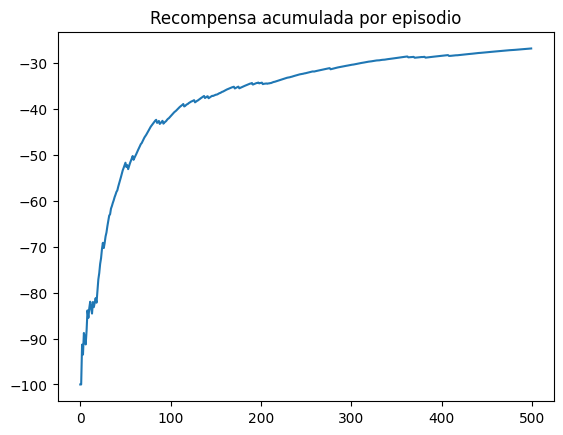

In [17]:
# Recompensa por episodio SARSA
plot_reward_per_episode(reward_ep)



Al principio la recompensa promedio está cerca de -100 el agente cae mucho al acantilado o da muchas vueltas sin llegar.

A medida que pasan los episodios, la curva sube hasta alrededor de -30.

Eso significa que con SARSA el agente va aprendiendo una política mejor.

Sigue siendo negativa (porque cada paso resta -1), pero pasa de trayectorias muy malas (muchos pasos, caídas) a trayectorias más cortas y seguras por eso la recompensa promedio mejora.

Veamos pasos por episodio SARSA

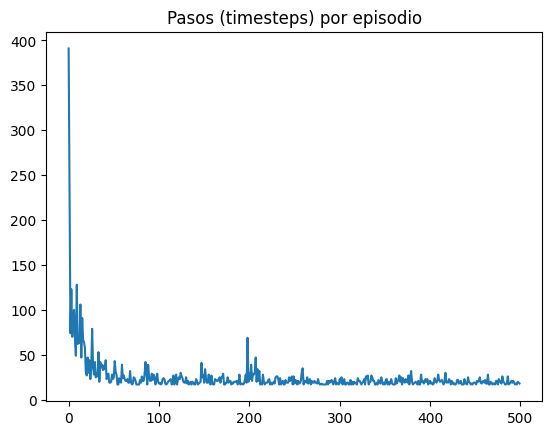

In [18]:
plot_steps_per_episode(timesteps_ep)

Los primeros episodios tienen muchísimos pasos (picos grandes, hasta 400).

Después, rápidamente los episodios bajan a menos de 50 pasos, con ruido al principio.

Hacia el final de los 500 episodios, la mayoría de los episodios está alrededor de 20–30 pasos.

Podemos decir que al principio el agente explora a lo loco, se pierde, cae, da vueltas. Después de varias actualizaciones con SARSA, encuentra caminos más directos, cada vez tarda menos en llegar a la meta.

Suavizando...

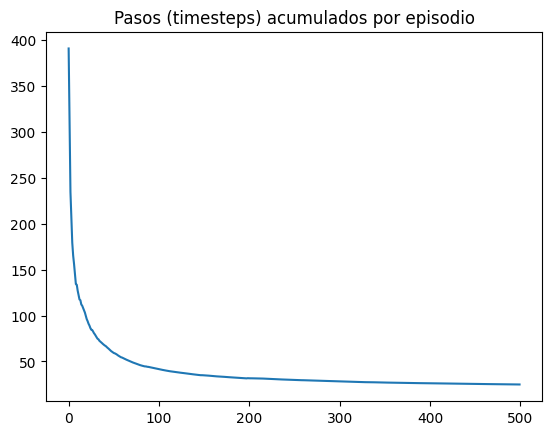

In [19]:
plot_steps_per_episode_smooth(timesteps_ep)

Esto es el resumen de lo anterior: el agente converge a una política en la que tarda pocos pasos en llegar, en promedio.

------
### Resultados con SARSA en CliffWalking

Al entrenar el agente con SARSA durante 500 episodios, observamos que la
recompensa acumulada por episodio mejora de forma sostenida: al inicio
los valores están cerca de -100 (episodios largos, con caídas frecuentes
en el acantilado), mientras que hacia el final la recompensa promedio
asciende a valores cercanos a -30. Esto indica que el agente aprende a
evitar trayectorias muy malas y a tomar caminos más eficientes.

En paralelo, el número de pasos por episodio cae drásticamente: los
primeros episodios pueden superar los 300–400 pasos, pero luego
disminuyen y se estabilizan alrededor de 20–30 pasos. La curva
suavizada de pasos muestra una convergencia clara, lo que confirma que
SARSA aprende una política que llega a la meta en menos tiempo y con
mejor recompensa esperada.


#### Análisis de matriz de acción-valor y política óptima


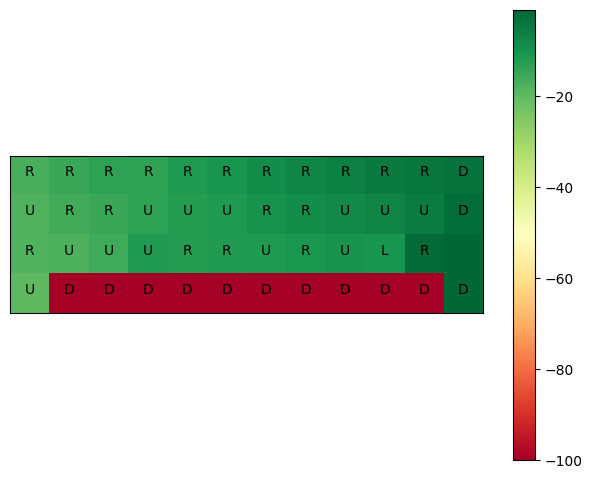


 Matriz de mejor acción-valor (en números): 

 [[ -17.23954428  -15.14316652  -13.47940719  -13.86734791  -11.50591433
   -10.42824021   -8.92910114   -7.36906975   -6.09772006   -5.02260286
    -4.246717     -3.48743802]
 [ -18.17688817  -16.29163152  -15.09887514  -13.57191616  -12.57200446
   -11.46204211  -10.28051994   -8.75636874   -8.02140089   -7.17268501
    -5.41325753   -2.24362335]
 [ -18.16818774  -17.96726471  -16.02741607  -12.12753358  -12.36502775
   -11.94064567  -11.56233996  -10.96253903   -9.96154144  -10.28531687
    -2.00258599   -1.        ]
 [ -19.72790699 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [20]:
draw_value_matrix(q_sarsa)

La matriz de valores Q obtenida con SARSA muestra que los estados
correspondientes al acantilado (fila inferior, columnas 1 a 10) tienen
valor alrededor de -100, mientras que la meta tiene valor -1 y los
estados de las filas superiores toman valores progresivamente menos
negativos a medida que se acercan a la meta. Esto indica que el agente
ha aprendido que caer en el acantilado es extremadamente costoso, mientras
que avanzar por las filas superiores hacia la derecha resulta mucho más
seguro.

En el mapa de “mejor acción”, se observa que desde el estado inicial la
mejor acción es subir (`U`) y luego avanzar principalmente hacia la
derecha (`R`) por las filas superiores. Es decir, SARSA aprende una
política que evita recorrer la fila del acantilado y prefiere un camino
más largo pero más seguro, coherente con el fuerte castigo de -100 por
caída.


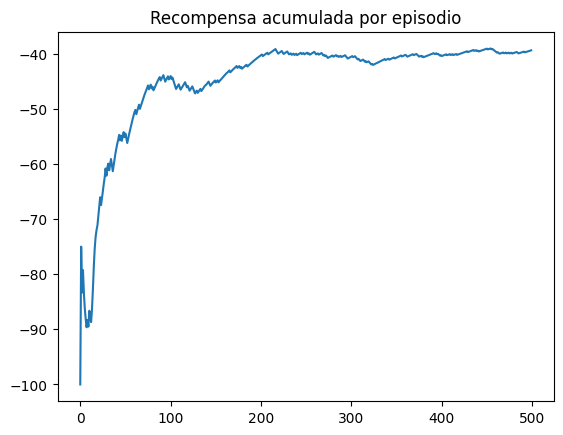

In [21]:
# Recompensa por episodio Q-Learning
plot_reward_per_episode(reward_ep_q)

La curva sube rápido desde -100 a -40 .

Con Q-learning intenta ir por la ruta óptima (corta), aunque pase muy cerca del acantilado. 
Esa ruta corta a veces le sale mal por culpa de la exploración ,cae y recibe -100.
Por eso la curva final queda más serruchada.

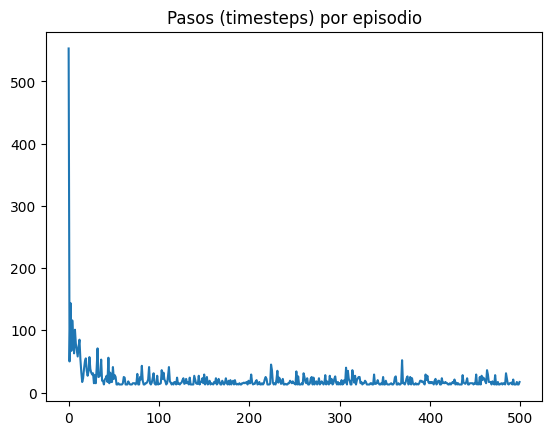

In [22]:
plot_steps_per_episode(timesteps_ep_q)

Q-learning baja muy rápido de 500 pasos a menos de 50, luego se estabiliza más o menos entre 20–30 pasos pero con picos esporádicos.

Esto es lo esperado en Q-learning porque converge rápido pero es más inestable por su estilo optimista.


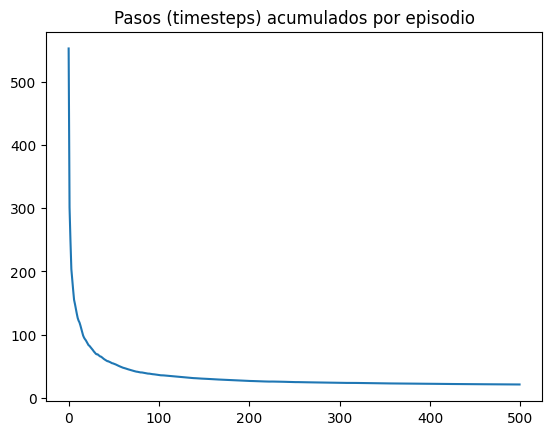

In [23]:
plot_steps_per_episode_smooth(timesteps_ep_q)

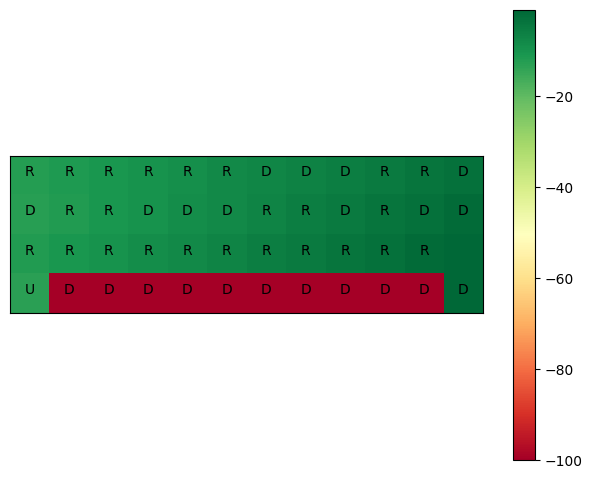


 Matriz de mejor acción-valor (en números): 

 [[ -12.3189387   -11.59140422  -10.84866451   -9.96310256   -9.18688713
    -8.34095048   -7.4542462    -6.72926453   -5.82792094   -4.91990551
    -3.95712468   -2.99947958]
 [ -12.87149892  -11.96404923  -10.98713428   -9.99742173   -8.99937844
    -7.99976186   -6.99991029   -5.99997592   -4.99999754   -3.99999928
    -2.99999988   -2.        ]
 [ -12.          -11.          -10.           -9.           -8.
    -7.           -6.           -5.           -4.           -3.
    -2.           -1.        ]
 [ -13.         -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [24]:
draw_value_matrix(q_qlearning)

Q-learning descubre que avanzar pegado al acantilado produce trayectorias más cortas y, por lo tanto, con menor castigo acumulado (–1 por paso). Como
el algoritmo es off-policy y asume que en el futuro siempre tomará la acción óptima, termina privilegiando caminos riesgosos donde una caída implica –100, pero si no se cae la trayectoria total es mucho más
barata.


### Comparación entre SARSA y Q-Learning en el entorno CliffWalking

Al comparar ambos algoritmos podemos observar diferencias claras en la
forma en que convergen.

**SARSA**, al ser un método *on-policy*, aprende teniendo en cuenta la
política que realmente ejecuta el agente (incluyendo la exploración
ε-greedy). Como consecuencia, converge hacia una política más
conservadora: evita caminar cerca del acantilado y prefiere trayectorias
más seguras. Esto se observa en la recompensa acumulada, que alcanza
valores cercanos a –30, y en la política aprendida, donde las flechas
indican que el agente sube primero y avanza por las filas superiores.

En cambio, **Q-Learning** es un método *off-policy* y asume que en el
futuro siempre tomará la acción óptima, incluso si en el presente está
explorando. Esto lo vuelve más “optimista” y conduce a políticas más
arriesgadas. En la matriz de acciones se observa que Q-Learning avanza
mucho más pegado al acantilado. Aunque esto produce caminos más cortos,
también incrementa la variabilidad y la probabilidad de caídas durante la
exploración. Esto explica por qué su recompensa converge cerca de –40,
peor que SARSA pero con mayor velocidad inicial.

En resumen, SARSA produce políticas más seguras y estables, mientras que
Q-Learning converge más rápidamente hacia políticas potencialmente
óptimas pero significativamente más riesgosas.


# Ajuste de hiperparametros para el algoritmo SARSA

In [25]:
env = gym.make("CliffWalking-v1")
actions = range(env.action_space.n)

# configuración base
base_hyperparameters = {
    "alpha": 0.5,
    "gamma": 1.0,
    "epsilon": 0.1,
    "tau": 25,
    "n_actions": env.action_space.n,
}
episodes_to_run = 500


En este bloque variamos el hiperparámetro **α (alpha)**, que determina cuánto influye el nuevo conocimiento sobre el antiguo durante la
actualización de los valores Q. Valores bajos de α hacen que el aprendizaje sea más lento pero más estable; valores altos permiten
aprender más rápido, pero pueden generar oscilaciones o inestabilidad.

Para analizar este efecto, probamos tres valores distintos:

- α = 0.1  → aprendizaje lento  
- α = 0.5  → valor intermedio (generalmente estable)  
- α = 0.9  → aprendizaje rápido pero potencialmente inestable

En cada experimento reiniciamos los valores Q desde cero, mantenemos todos los demás hiperparámetros fijos y ejecutamos SARSA durante 500
episodios. Finalmente registramos la recompensa promedio final para cada valor de α.

In [26]:
alphas = [0.1, 0.5, 0.9]
results_alpha = {}

for a in alphas:
    print(f"\n=== Alpha = {a} ===")
    hyperparameters = base_hyperparameters.copy()
    hyperparameters["alpha"] = a

    # Q arranca vacío en cada experimento
    q = {}
    random_state = np.random.RandomState(42)

    avg_reward, timesteps_ep, reward_ep = run(
        learn_SARSA,
        hyperparameters,
        episodes_to_run,
        env,
        actions,
        q,
        random_state,
    )

    results_alpha[a] = (avg_reward, timesteps_ep, reward_ep)
    print(f"Recompensa promedio final: {avg_reward:.2f}")



=== Alpha = 0.1 ===
Recompensa promedio final: -36.23

=== Alpha = 0.5 ===
Recompensa promedio final: -26.92

=== Alpha = 0.9 ===
Recompensa promedio final: -47.02


- Con **α = 0.1**, el agente actualiza muy lentamente los valores Q. El aprendizaje es
  más estable pero también más lento, lo que se traduce en una recompensa final peor
  (el agente no logra mejorar lo suficiente).

- Con **α = 0.5**, se logra el mejor desempeño. El agente incorpora información nueva
  a un ritmo adecuado sin volverse inestable, permitiendo converger a una política con
  mejor recompensa acumulada.

- Con **α = 0.9**, el aprendizaje es muy agresivo. Esto provoca oscilaciones fuertes
  en los valores Q y una política menos estable, generando una recompensa final
  significativamente peor que las otras configuraciones.

En conclusión, el valor **intermedio α = 0.5** ofrece el mejor balance entre
estabilidad y velocidad de aprendizaje, logrando la mejor recompensa final entre
las tres configuraciones evaluadas.

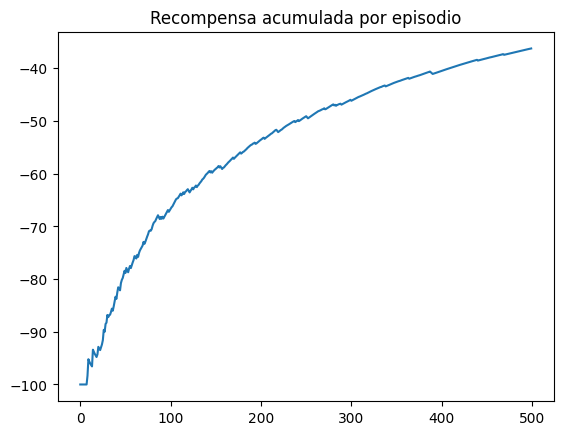

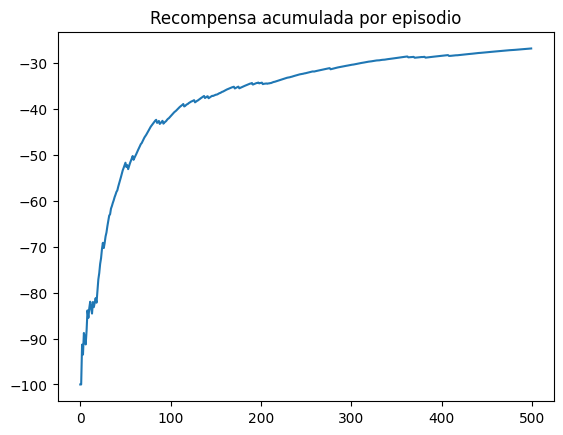

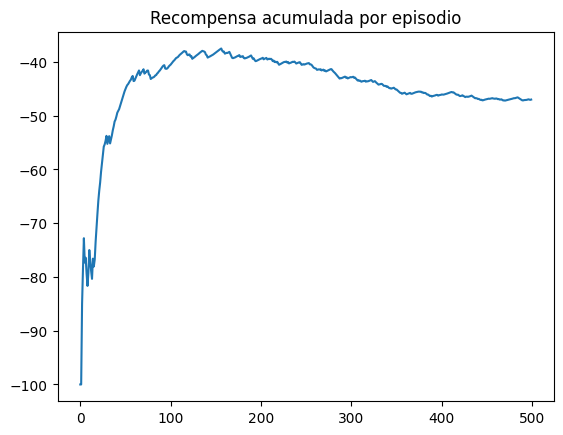

In [27]:
plot_reward_per_episode(results_alpha[0.1][2])
plot_reward_per_episode(results_alpha[0.5][2])
plot_reward_per_episode(results_alpha[0.9][2])


En este bloque analizamos cómo influye el hiperparámetro **ε**, que
controla la cantidad de exploración en la política ε-greedy. Con
probabilidad ε el agente elige una acción completamente aleatoria, y con
probabilidad (1–ε) elige la mejor acción según los valores Q
aprendidos hasta el momento.

Probamos tres configuraciones de exploración:

- **ε = 0.01** → casi no explora (muy explotador).
- **ε = 0.1** → equilibrio exploración/explotación.
- **ε = 0.3** → explora mucho más de lo habitual.


In [28]:
epsilons = [0.01, 0.1, 0.3]
results_epsilon = {}

for e in epsilons:
    print(f"\n=== Epsilon = {e} ===")
    hyperparameters = base_hyperparameters.copy()
    hyperparameters["epsilon"] = e

    q = {}
    random_state = np.random.RandomState(42)

    avg_reward, timesteps_ep, reward_ep = run(
        learn_SARSA,
        hyperparameters,
        episodes_to_run,
        env,
        actions,
        q,
        random_state,
    )

    results_epsilon[e] = (avg_reward, timesteps_ep, reward_ep)
    print(f"Recompensa promedio final: {avg_reward:.2f}")



=== Epsilon = 0.01 ===
Recompensa promedio final: -18.95

=== Epsilon = 0.1 ===
Recompensa promedio final: -26.92

=== Epsilon = 0.3 ===
Recompensa promedio final: -47.23


- Con **ε = 0.01**, el agente explora muy poco: casi siempre elige la
  mejor acción según su conocimiento actual. Esto permite que converja
  rápidamente hacia una política razonablemente buena y estable, lo que
  explica la mejor recompensa final (–18.95). Sin embargo, este nivel
  tan bajo de exploración puede hacer que el agente quede atrapado en
  políticas subóptimas si las primeras experiencias no son buenas.

- Con **ε = 0.1**, se observa un compromiso entre exploración y
  explotación. La recompensa final empeora con respecto a ε = 0.01,
  porque el agente sigue explorando durante el entrenamiento, y esto
  introduce más ruido y episodios fallidos. Aun así, este valor suele
  ser más robusto para entornos más complejos.

- Con **ε = 0.3**, la exploración es muy alta. El agente toma acciones
  aleatorias con mucha frecuencia, lo que evita cualquier convergencia
  temprana pero también genera trayectorias muy inestables y recompensa
  acumulada significativamente peor (–47.23).

En resumen, estos resultados confirman que valores muy altos de
exploración dificultan la convergencia, mientras que valores muy
bajos permiten una recompensa final mejor.

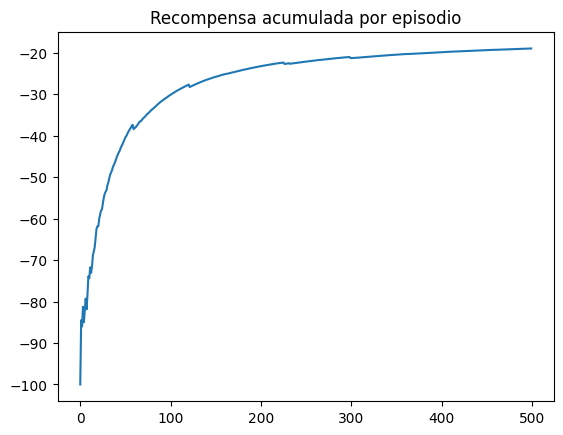

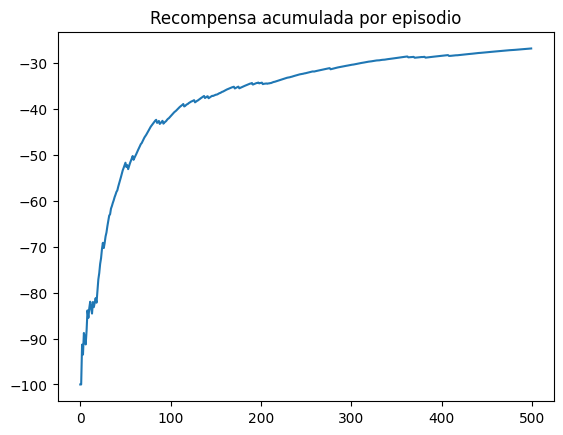

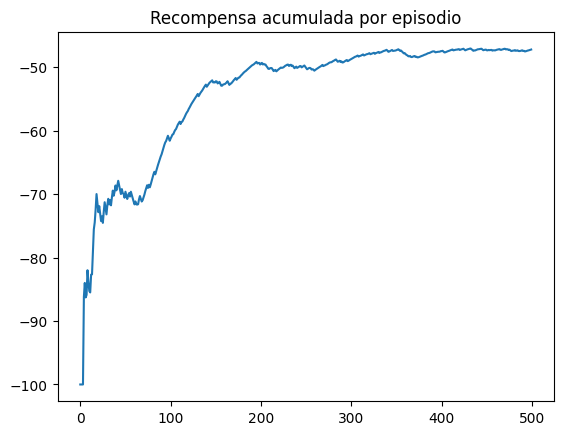

In [29]:
plot_reward_per_episode(results_epsilon[0.01][2])
plot_reward_per_episode(results_epsilon[0.1][2])
plot_reward_per_episode(results_epsilon[0.3][2])


En este bloque analizamos el impacto del hiperparámetro **γ**, que
controla la importancia relativa de las recompensas futuras frente a las
inmediatas. Valores bajos de γ hacen que el agente priorice recompensas
instantáneas, mientras que valores altos fomentan la planificación a
largo plazo.

Probamos tres configuraciones típicas:

- **γ = 0.5** → el agente solo valora parcialmente el futuro.  
- **γ = 0.9** → equilibrio entre presente y futuro.  
- **γ = 1.0** → el agente valora el futuro igual que el presente.


In [30]:
gammas = [0.5, 0.9, 1.0]
results_gamma = {}

for g in gammas:
    print(f"\n=== Gamma = {g} ===")
    hyperparameters = base_hyperparameters.copy()
    hyperparameters["gamma"] = g

    q = {}
    random_state = np.random.RandomState(42)

    avg_reward, timesteps_ep, reward_ep = run(
        learn_SARSA,
        hyperparameters,
        episodes_to_run,
        env,
        actions,
        q,
        random_state,
    )

    results_gamma[g] = (avg_reward, timesteps_ep, reward_ep)
    print(f"Recompensa promedio final: {avg_reward:.2f}")



=== Gamma = 0.5 ===
Recompensa promedio final: -52.90

=== Gamma = 0.9 ===
Recompensa promedio final: -30.75

=== Gamma = 1.0 ===
Recompensa promedio final: -26.92


- Con **γ = 0.5**, el agente prioriza demasiado las recompensas inmediatas.
  En el entorno CliffWalking esto es perjudicial, porque incentiva al
  agente a tomar decisiones cortoplacistas que evitan el castigo de cada
  paso, pero lo llevan a cometer errores graves como acercarse demasiado
  al acantilado o no construir una ruta eficiente hacia la meta. Esto se
  refleja en la recompensa final extremadamente baja.

- Con **γ = 0.9**, el agente comienza a valorar mejor las consecuencias
  futuras de sus acciones. Esto mejora notablemente la recompensa
  promedio, ya que aprende una política más coherente con el objetivo de
  llegar a la meta de forma segura.

- Con **γ = 1.0**, el agente considera el futuro y el presente con igual
  importancia. En este entorno, donde el costo futuro puede ser muy alto
  (caída al acantilado, –100), esta estrategia resulta la más adecuada,
  permitiendo alcanzar la mejor recompensa final entre todas las
  configuraciones probadas.

En conclusión, los resultados muestran que valores altos de γ favorecen
la convergencia a políticas más eficientes y seguras, mientras que
valores bajos degradan drásticamente el desempeño al incentivar acciones
miopes o excesivamente cortoplacistas.

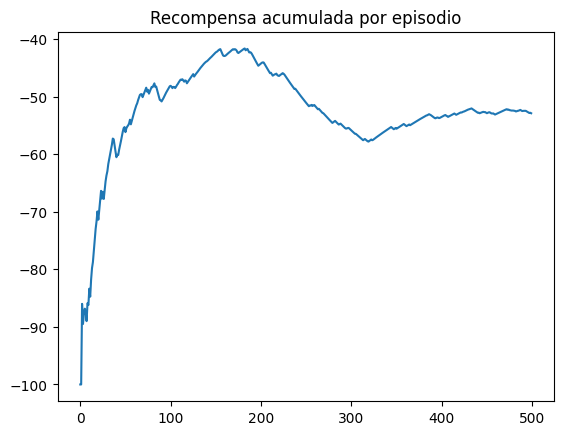

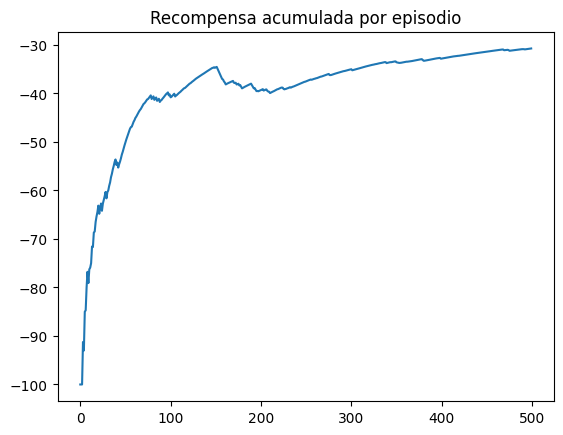

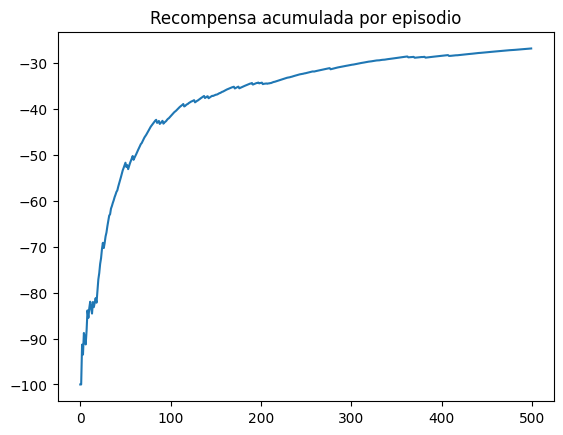

In [31]:
plot_reward_per_episode(results_gamma[0.5][2])
plot_reward_per_episode(results_gamma[0.9][2])
plot_reward_per_episode(results_gamma[1.0][2])

# Ajuste de hiperparametros para el algoritmo Q-Learning

Además de analizar los hiperparámetros sobre SARSA, repetimos los experimentos variando α, ε y γ pero utilizando ahora el algoritmo
Q-learning. El objetivo es verificar si se observan tendencias similares en la convergencia (por ejemplo, valores intermedios de α y γ altos
mostrando mejor desempeño) y comparar la sensibilidad de Q-learning frente a estos parámetros.


In [32]:
env = gym.make("CliffWalking-v1")
actions = range(env.action_space.n)

# configuración base para Q-learning
base_hyperparameters_q = {
    "alpha": 0.5,
    "gamma": 1.0,
    "epsilon": 0.1,
    "tau": 25,
    "n_actions": env.action_space.n,
}

episodes_to_run = 500


In [33]:
alphas = [0.1, 0.5, 0.9]
results_alpha_q = {}

for a in alphas:
    print(f"\n=== Q-learning | Alpha = {a} ===")
    hyperparameters = base_hyperparameters_q.copy()
    hyperparameters["alpha"] = a

    # Q arranca vacío en cada experimento
    q = {}
    random_state = np.random.RandomState(42)

    avg_reward_q, timesteps_ep_q, reward_ep_q = run(
        learn_Q_learning,
        hyperparameters,
        episodes_to_run,
        env,
        actions,
        q,
        random_state,
    )

    results_alpha_q[a] = (avg_reward_q, timesteps_ep_q, reward_ep_q)
    print(f"Recompensa promedio final (Q-learning): {avg_reward_q:.2f}")



=== Q-learning | Alpha = 0.1 ===
Recompensa promedio final (Q-learning): -41.55

=== Q-learning | Alpha = 0.5 ===
Recompensa promedio final (Q-learning): -39.40

=== Q-learning | Alpha = 0.9 ===
Recompensa promedio final (Q-learning): -37.95


A diferencia de SARSA, donde valores intermedios de α suelen funcionar mejor, en Q-learning observamos una tendencia más marcada a medida que
aumenta la tasa de aprendizaje α, la recompensa final mejora.
Esto tiene sentido debido a que Q-learning actualiza los valores Q utilizando siempre la acción óptima futura (independientemente de la acción realmente tomada), valores
de α más altos permiten incorporar más rápidamente la estimación optimista del futuro. Esto acelera la convergencia hacia una política más agresiva, aunque potencialmente riesgosa.


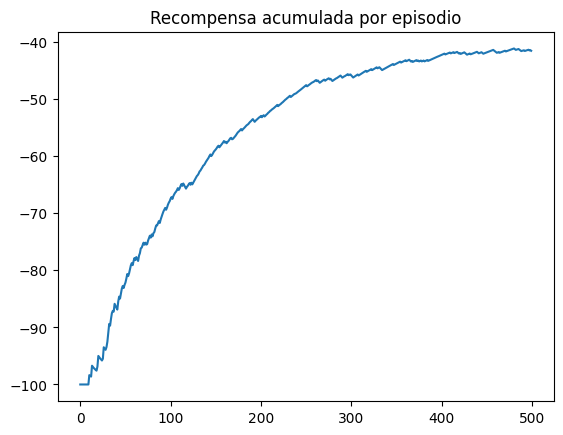

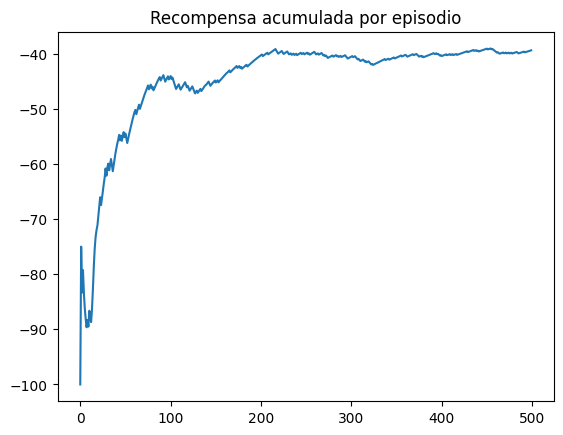

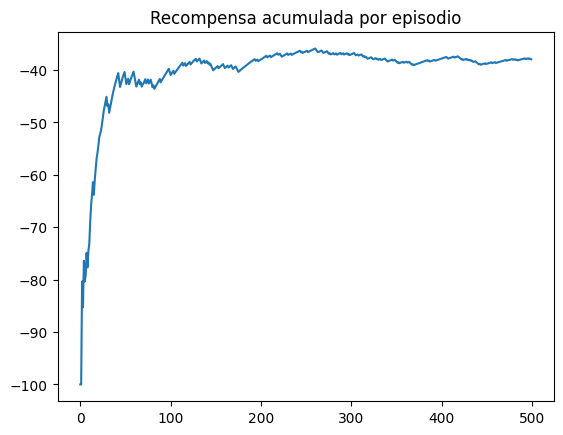

In [34]:
plot_reward_per_episode(results_alpha_q[0.1][2])
plot_reward_per_episode(results_alpha_q[0.5][2])
plot_reward_per_episode(results_alpha_q[0.9][2])


In [35]:
epsilons = [0.01, 0.1, 0.3]
results_epsilon_q = {}

for e in epsilons:
    print(f"\n=== Q-learning | Epsilon = {e} ===")
    hyperparameters = base_hyperparameters_q.copy()
    hyperparameters["epsilon"] = e

    q = {}
    random_state = np.random.RandomState(42)

    avg_reward_q, timesteps_ep_q, reward_ep_q = run(
        learn_Q_learning,
        hyperparameters,
        episodes_to_run,
        env,
        actions,
        q,
        random_state,
    )

    results_epsilon_q[e] = (avg_reward_q, timesteps_ep_q, reward_ep_q)
    print(f"Recompensa promedio final (Q-learning): {avg_reward_q:.2f}")



=== Q-learning | Epsilon = 0.01 ===
Recompensa promedio final (Q-learning): -19.40

=== Q-learning | Epsilon = 0.1 ===
Recompensa promedio final (Q-learning): -39.40

=== Q-learning | Epsilon = 0.3 ===
Recompensa promedio final (Q-learning): -68.22


En Q-learning, el parámetro de exploración ε tiene un impacto muy fuerte en el desempeño. Cuando ε es muy bajo (0.01), el agente explora muy
poco y se comporta de forma casi determinista siguiendo los valores Q que va aprendiendo. Esto favorece la convergencia hacia la política
“óptima” que Q-learning tiende a aprender en CliffWalking: una ruta cercana al acantilado pero corta, que resulta eficiente siempre que no ocurran caídas.

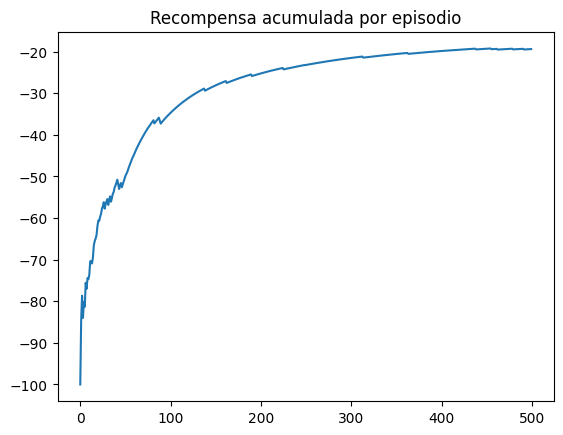

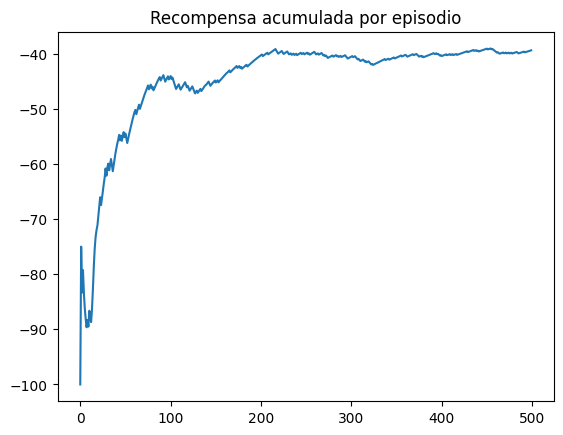

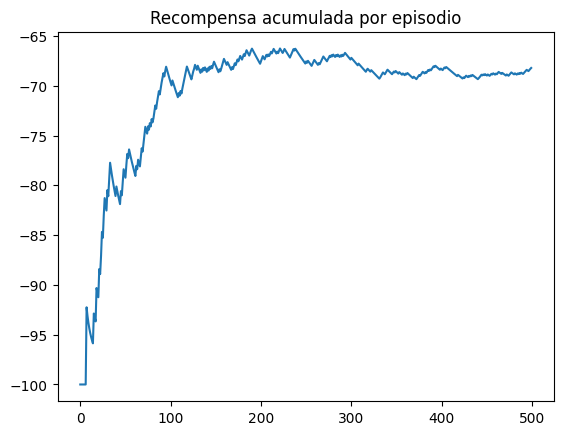

In [36]:
plot_reward_per_episode(results_epsilon_q[0.01][2])
plot_reward_per_episode(results_epsilon_q[0.1][2])
plot_reward_per_episode(results_epsilon_q[0.3][2])

In [37]:
gammas = [0.5, 0.9, 1.0]
results_gamma_q = {}

for g in gammas:
    print(f"\n=== Q-learning | Gamma = {g} ===")
    hyperparameters = base_hyperparameters_q.copy()
    hyperparameters["gamma"] = g

    q = {}
    random_state = np.random.RandomState(42)

    avg_reward_q, timesteps_ep_q, reward_ep_q = run(
        learn_Q_learning,
        hyperparameters,
        episodes_to_run,
        env,
        actions,
        q,
        random_state,
    )

    results_gamma_q[g] = (avg_reward_q, timesteps_ep_q, reward_ep_q)
    print(f"Recompensa promedio final (Q-learning): {avg_reward_q:.2f}")



=== Q-learning | Gamma = 0.5 ===
Recompensa promedio final (Q-learning): -39.14

=== Q-learning | Gamma = 0.9 ===
Recompensa promedio final (Q-learning): -38.88

=== Q-learning | Gamma = 1.0 ===
Recompensa promedio final (Q-learning): -39.40


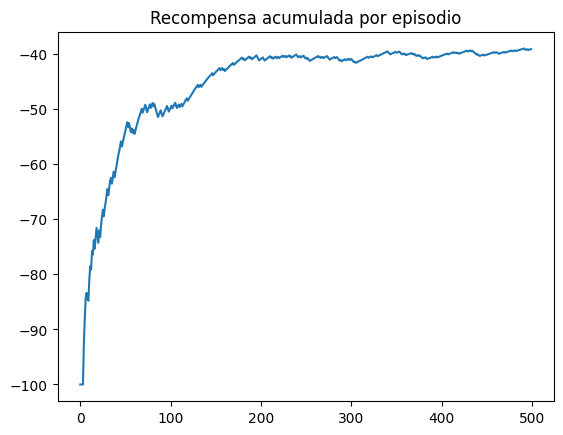

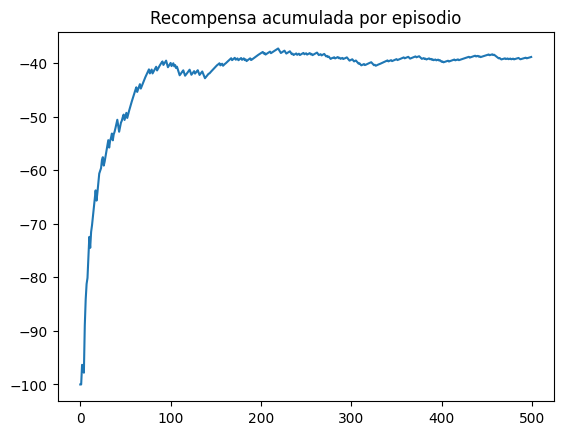

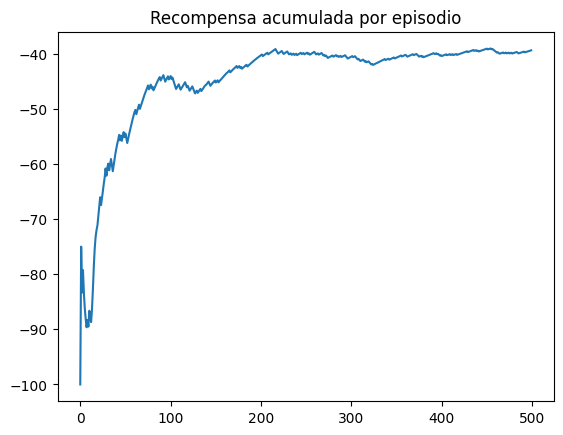

In [38]:
plot_reward_per_episode(results_gamma_q[0.5][2])
plot_reward_per_episode(results_gamma_q[0.9][2])
plot_reward_per_episode(results_gamma_q[1.0][2])

Q-learning resulta robusto frente a variaciones en γ en este entorno: la convergencia y la recompensa final cambian muy poco al modificar este parámetro. Esto contrasta con SARSA, donde γ altos
favorecían claramente el desempeño.

# Exploracion SOFTMAX

La política Softmax será implementada y evaluada sobre SARSA y no sobre Q-learning por razones metodológicas y conceptuales. SARSA es un método
on-policy, lo que implica que aprende exactamente con la misma política que utiliza para interactuar con el entorno. Esto significa que cualquier
cambio en la política de exploración —como reemplazar ε-greedy por Softmax— impacta directamente en la actualización de los valores Q.

Por el contrario, Q-learning es un método off-policy que actualiza sus valores Q utilizando siempre la acción óptima futura (máximo Q), sin
importar la acción que realmente tomó el agente durante la exploración. Esta propiedad provoca que Q-learning aprenda como si siguiera una
política totalmente determinista, aun cuando su política de exploración sea Softmax. En consecuencia, la política Softmax tendría poco efecto 
sobre la actualización de Q-learning, y el análisis de su impacto sería poco informativo.

Dado que el objetivo del punto 4 es estudiar el comportamiento de la política de exploración Softmax, la elección de SARSA es la más adecuada
porque permite observar claramente cómo la probabilidad de cada acción influye en el aprendizaje y en la convergencia del agente.


In [39]:
def run_softmax(
    learning_function: Callable,
    hyperparameters: dict,
    episodes_to_run: int,
    env: gym.Env,
    actions: range,
    q: dict,
    random_state: np.random.RandomState,
) -> Tuple[float, np.ndarray, np.ndarray]:

    timesteps_of_episode = []
    reward_of_episode = []

    for _ in range(episodes_to_run):

        state, _ = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # acción inicial según SOFTMAX
        action = choose_action_softmax(
            state, actions, q, hyperparameters, random_state
        )

        while not done:

            next_state, reward, terminated, truncated, _ = env.step(action)

            # acción siguiente SOFTMAX
            next_action = choose_action_softmax(
                next_state, actions, q, hyperparameters, random_state
            )

            episode_reward += reward

            learning_function(
                state,
                action,
                reward,
                next_state,
                next_action,
                hyperparameters,
                q
            )

            done = terminated or truncated

            if not done and t < 2000:
                state = next_state
                action = next_action
            else:
                done = True
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t+1)])
                reward_of_episode = np.append(
                    reward_of_episode, max(episode_reward, -100)
                )

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode


In [40]:
q = {}

hyperparameters_softmax = {
    "alpha": 0.5,
    "gamma": 1.0,
    "tau": 25,     # temperatura
    "epsilon": 0.1,  # no se usa aqui pero lo dejamos
    "n_actions": env.action_space.n,
}

episodes_to_run = 500
env = gym.make("CliffWalking-v1")
actions = range(env.action_space.n)
random_state = np.random.RandomState(42)

avg_steps_soft, timesteps_soft, reward_soft = run_softmax(
    learn_SARSA,     
    hyperparameters_softmax,
    episodes_to_run,
    env,
    actions,
    q,
    random_state
)


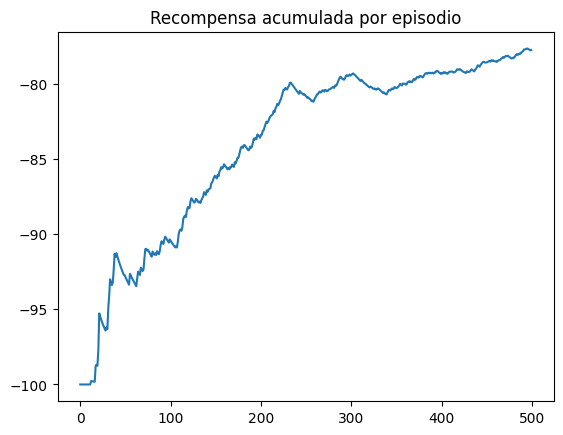

In [41]:
plot_reward_per_episode(reward_soft)


La curva de recompensa acumulada muestra una mejora progresiva, pero mucho más lenta y ruidosa en comparación con la versión ε-greedy. Esto
se debe a que Softmax con temperatura τ = 25 produce una exploración muy intensa: las probabilidades de las acciones son casi uniformes,
incluso cuando el agente ya comenzó a aprender valores Q diferenciados.

Como consecuencia, el agente nunca deja de explorar de manera significativa y no llega a consolidar una política estable tan rápidamente como con ε-greedy. El nivel de ruido en la convergencia y la
recompensa final relativamente baja (alrededor de –80) reflejan este comportamiento.

En entornos como CliffWalking, donde la penalización por caer en el acantilado es muy alta, la exploración constante de Softmax puede llevar a decisiones más arriesgadas.

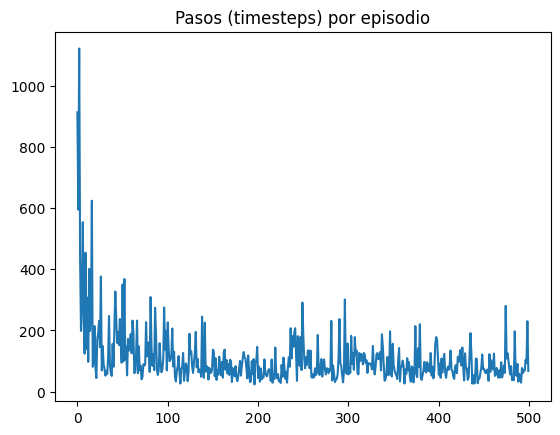

In [42]:
plot_steps_per_episode(timesteps_soft)

El gráfico de timesteps refleja un comportamiento significativamente más variable e inestable que el observado con ε-greedy. Debido a que en la política Softmax  el agente continúa explorando de manera
intensa a lo largo de todo el entrenamiento.

Esto produce episodios extremadamente largos al inicio (superiores a 900 pasos), y aunque la duración disminuye con el tiempo, la curva continúa mostrando picos frecuentes de 200–300 pasos incluso en etapas
tardías. Esta alta variabilidad indica que el agente no termina de consolidar una política estable y sigue realizando acciones aleatorias con cierta regularidad.



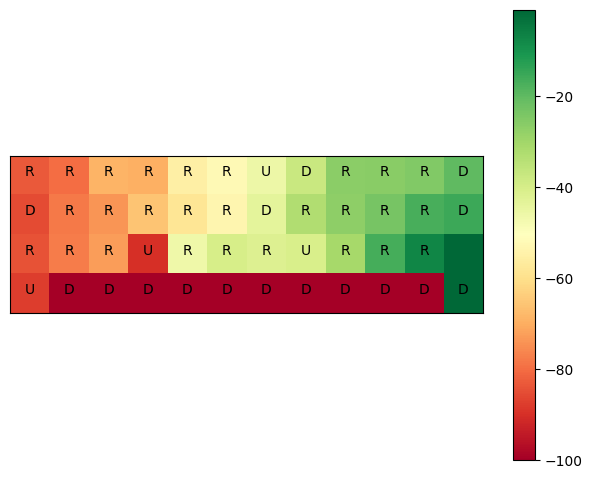


 Matriz de mejor acción-valor (en números): 

 [[ -83.08710061  -80.24893442  -68.95341989  -69.52423927  -55.28016454
   -52.25011948  -46.11595357  -37.43094647  -26.75975713  -26.30807492
   -25.2987771   -20.12574633]
 [ -85.50668642  -78.12902898  -73.73346351  -65.65393921  -58.41487084
   -53.58481888  -43.64513307  -32.83797849  -26.95906884  -23.60189796
   -17.21462143  -15.49706909]
 [ -84.52057211  -77.95197516  -72.741365    -89.96916309  -46.5442019
   -40.32814501  -41.7539113   -40.48111352  -31.0657185   -16.57734363
    -7.49976423   -1.        ]
 [ -87.96502822 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [43]:
draw_value_matrix(q)


Cerca del acantilado aparecen acciones peligrosas (`D`), que en la versión ε-greedy casi nunca aparecían. La falta de un patrón claro indica que el
agente no terminó de consolidar una política estable y sigue realizando acciones subóptimas con probabilidad significativa.

In [44]:
env.close()

## Actividades

1. Implementar y ejecutar el algoritmo SARSA en "The Cliff".

2. Implementar y ejecutar el algoritmo Q-Learning en "The Cliff". ¿Cómo converge con respecto a SARSA? ¿A qué se debe? Comentar.

3. Ejecutando con distintos híper-parámetros, realizar una breve descripción sobre cómo afectan a la convergencia los distintos valores de $\alpha$, $\epsilon$ y $\gamma$.

4. (Opcional) Implementar política de exploración Softmax, en donde cada acción tiene una probabilidad $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\widetilde{a} \in A}e^{Q(s,\widetilde{a})/\tau}}$$

5. (Opcional) Implementar Dyna-Q a partir del algoritmo Q-Learning, incorporando una actualización mediante un modelo. Comentar cómo se desempeña respecto a los demás algoritmos.


Para dejar el lab listo para su corrección, dejar link a repo de Github con un notebook ejecutando el agente en la planilla enviada en Slack.

FIN